In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from utils.nn_utils import *
from utils.build import *

os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2024.2'
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2024.2/bin:' + os.environ['PATH']


models_path = 'models'
history_path = 'history'
project_folder = 'Projects'

# Params
n_classes = 10
train = False
n_epochs = 15

2025-09-26 23:55:37.000993: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 23:55:37.006602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 23:55:37.063179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-26 23:55:37.063259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-26 23:55:37.063488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Reshape to add channel dimension (28x28x1)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test  = x_test.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Split off a validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create tf.data.Dataset objects (optional but recommended for performance)
batch_size = 1024

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_data   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_data  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

train_size = len(x_train) 

input_shape = (28, 28, 1)
n_classes = 10

In [3]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

from functools import partial
prune_fn = partial(pruneFunction, steps=NSTEPS)


Number of training steps per epoch is 47


In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [8, 16]
neurons_per_dense_layer = [48, 24]
    

def build_cnn(filter=filters_per_conv_layer, neurons=neurons_per_dense_layer, input=input_shape):
    x = x_in = Input(input)
    for i, f in enumerate(filters_per_conv_layer):
        print(('Adding convolutional block {} with N={} filters').format(i, f))
        x = Conv2D(
            int(f),
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            use_bias=False,
            name='conv_{}'.format(i),
        )(x)
        x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
        x = Activation('relu', name='conv_act_%i' % i)(x)
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    x = Flatten()(x)

    for i, n in enumerate(neurons_per_dense_layer):
        print(('Adding dense block {} with N={} neurons').format(i, n))
        x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
        x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
        x = Activation('relu', name='dense_act_%i' % i)(x)
    x = Dense(int(n_classes), name='output_dense')(x)
    x_out = Activation('softmax', name='output_softmax')(x)

    model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')
    model.summary()
    
    return model


In [5]:
model = build_cnn()

Adding convolutional block 0 with N=8 filters
Adding convolutional block 1 with N=16 filters
Adding dense block 0 with N=48 neurons
Adding dense block 1 with N=24 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 26, 26, 8)         72        
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 26, 26, 8)         32        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
             

In [6]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 72
conv_1: 1152
dense_0: 19200
Layer dense_0 is too large (19200), are you sure you want to train?
dense_1: 1152
output_dense: 240


In [7]:
model_pruned = build_cnn()

model_pruned = tf.keras.models.clone_model(model_pruned, clone_function=prune_fn)

Adding convolutional block 0 with N=8 filters
Adding convolutional block 1 with N=16 filters
Adding dense block 0 with N=48 neurons
Adding dense block 1 with N=24 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 26, 26, 8)         72        
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 26, 26, 8)         32        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
             

In [8]:
save_path_prunned = os.path.join(models_path, 'pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.Crossentropy()
    OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=3e-3)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    model_pruned.save(save_path_prunned)


else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model(f'{models_path}/pruned_cnn_model.h5', custom_objects=co)

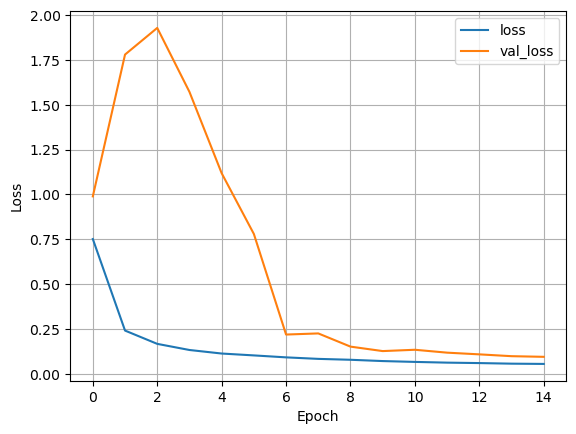

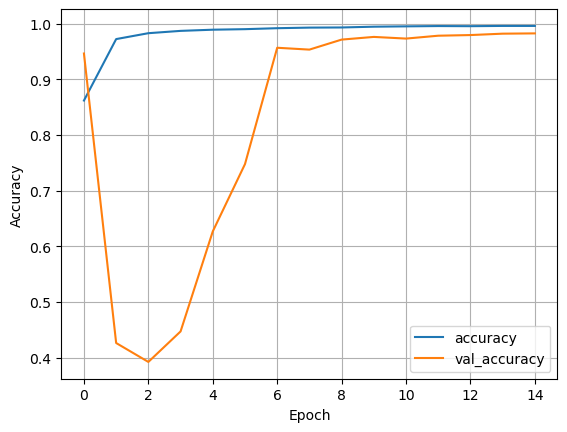

In [9]:
if train:
    plot_history(history.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history.history, f'{history_path}/baseline_cnn_pruned.history')
    
else:
    history = load_history(f'{history_path}/baseline_cnn_pruned.history')
    plot_history(history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')

In [10]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm


def build_q_cnn(filter=filters_per_conv_layer, neurons=neurons_per_dense_layer, input=input_shape):
    x = x_in = Input(shape=input_shape)

    for i, f in enumerate(filters_per_conv_layer):
        print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
        x = QConv2DBatchnorm(
            int(f),
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            bias_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            use_bias=True,
            name='fused_convbn_{}'.format(i),
        )(x)
        x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    x = Flatten()(x)

    for i, n in enumerate(neurons_per_dense_layer):
        print(('Adding QDense block {} with N={} neurons').format(i, n))
        x = QDense(
            n,
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            name='dense_%i' % i,
            use_bias=False,
        )(x)
        x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
        x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
    x = Dense(int(n_classes), name='output_dense')(x)
    x_out = Activation('softmax', name='output_softmax')(x)
    qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

    qmodel.summary()
    
    return qmodel

In [11]:
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
qmodel_pruned = build_q_cnn()

qmodel_pruned = tf.keras.models.clone_model(qmodel_pruned, clone_function=prune_fn)

Adding fused QConv+BN block 0 with N=8 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding QDense block 0 with N=48 neurons
Adding QDense block 1 with N=24 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 26, 26, 8)         113       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None, 11, 11, 16)        1233      
 chnorm)         

In [12]:
q_save_path_prunned = os.path.join(models_path, 'quantized_pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.8, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save(q_save_path_prunned)

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)

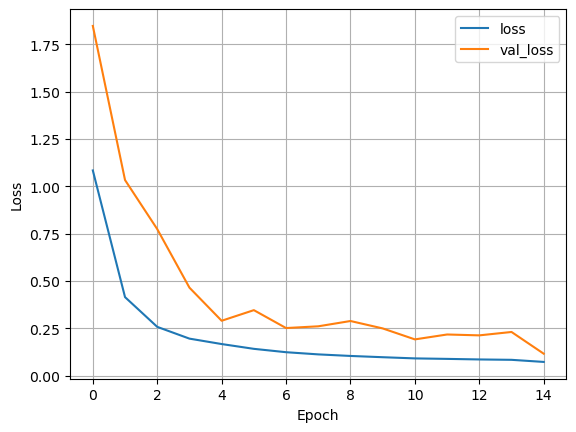

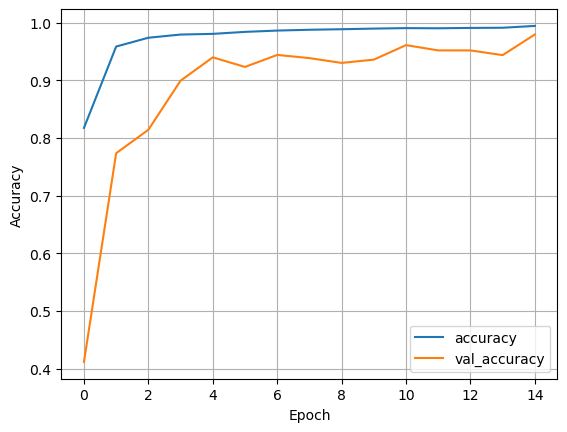

In [13]:
if train:
    plot_history(history.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history.history, f'{history_path}/quantized_cnn_prunned.history')
    
else:
    history = load_history(f'{history_path}/quantized_cnn_pruned.history')
    plot_history(history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')

In [14]:
predict_baseline = model_pruned.predict(x_test)
test_score_baseline = model_pruned.evaluate(x_test, y_test)

predict_qkeras = qmodel_pruned.predict(x_test)
test_score_qkeras = qmodel_pruned.evaluate(x_test, y_test)

print('Baseline Keras model accuracy: {:.2f}%'.format(test_score_baseline[1] * 100))
print('Quantized QKeras model accuracy: {:.2f}%'.format(test_score_qkeras[1] * 100))

313/313 [==============================] - 1s 3ms/step - loss: 0.1167 - accuracy: 0.9802
Baseline Keras model accuracy: 98.48%
Quantized QKeras model accuracy: 98.02%


Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


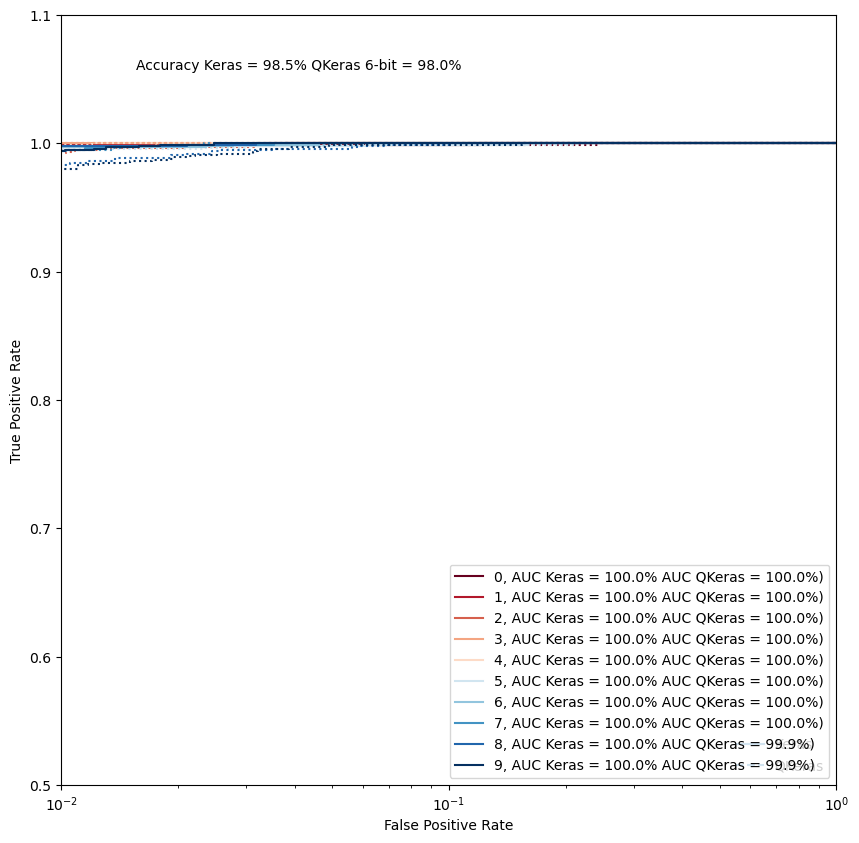

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = y_test[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = y_test[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    r'Accuracy Keras = {:.1f}% QKeras 6-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

Layer prune_low_magnitude_conv_0: % of zeros = 0.5
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.5
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


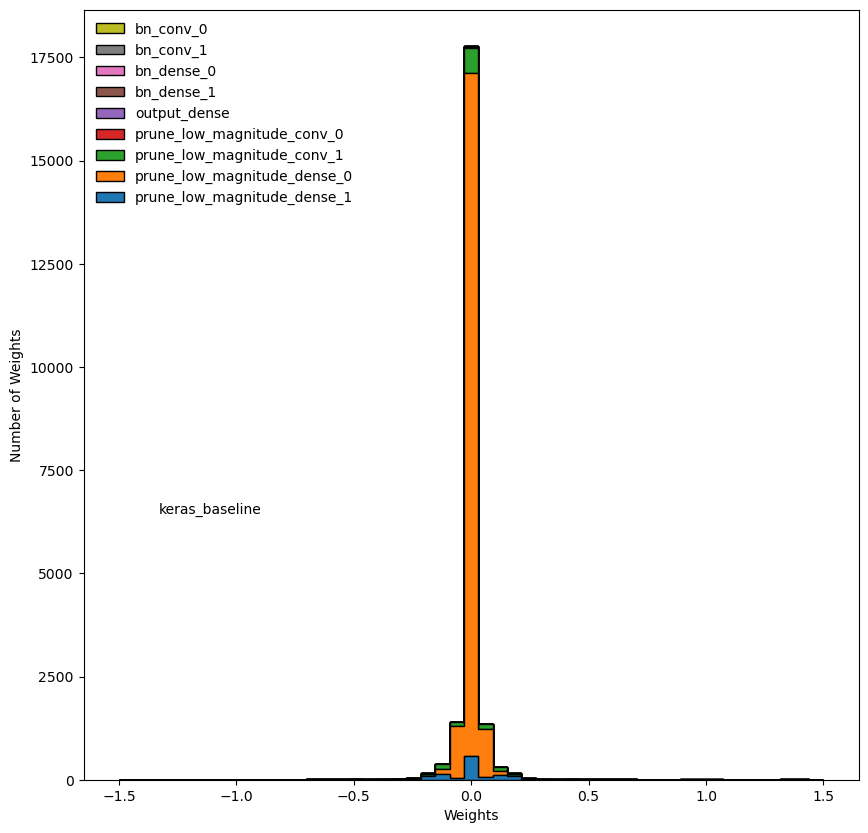

In [16]:
doWeights(model_pruned)

Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


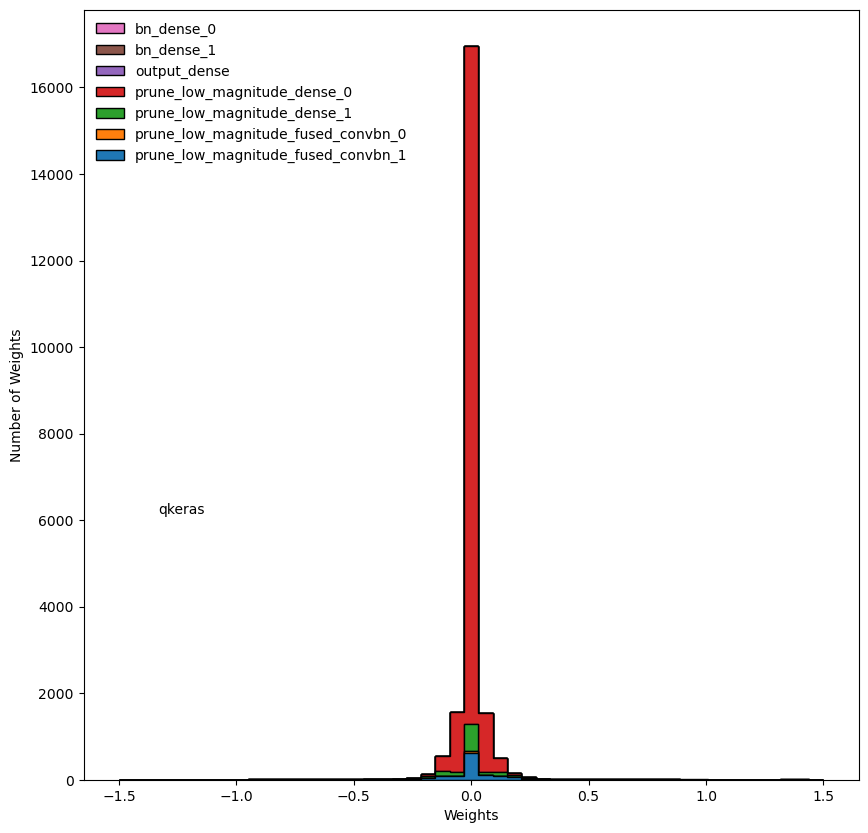

In [17]:
doWeights(qmodel_pruned)

In [18]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model(save_path_prunned, custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)
qmodel = strip_pruning(qmodel)

In [19]:
import hls4ml
import utils.plotting as plotting

# Generate base HLS config
hls_config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)

# Set model-level precision
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'

# Force Resource strategy globally
for lname, lcfg in hls_config['LayerName'].items():
    lcfg['Strategy'] = 'Resource'

# Inject computed reuse factors
reuse_factors = reuse_percentage_to_factors(model, serial_pct=0.125)
for lname, factor in reuse_factors.items():
    if lname in hls_config['LayerName']:
        hls_config['LayerName'][lname]['ReuseFactor'] = factor
    else:
        print(f"Warning: Layer {lname} not found in HLS config")

plotting.print_dict(hls_config)

save_proj_path = os.path.join(project_folder, 'Baseline')

# Convert and compile
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=hls_config,
    backend='Vitis',
    output_dir=save_proj_path,
    part='xck26-sfvc784-2LV-c',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    project_name='baseline_cnn', 
)
hls_model.compile()


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input s

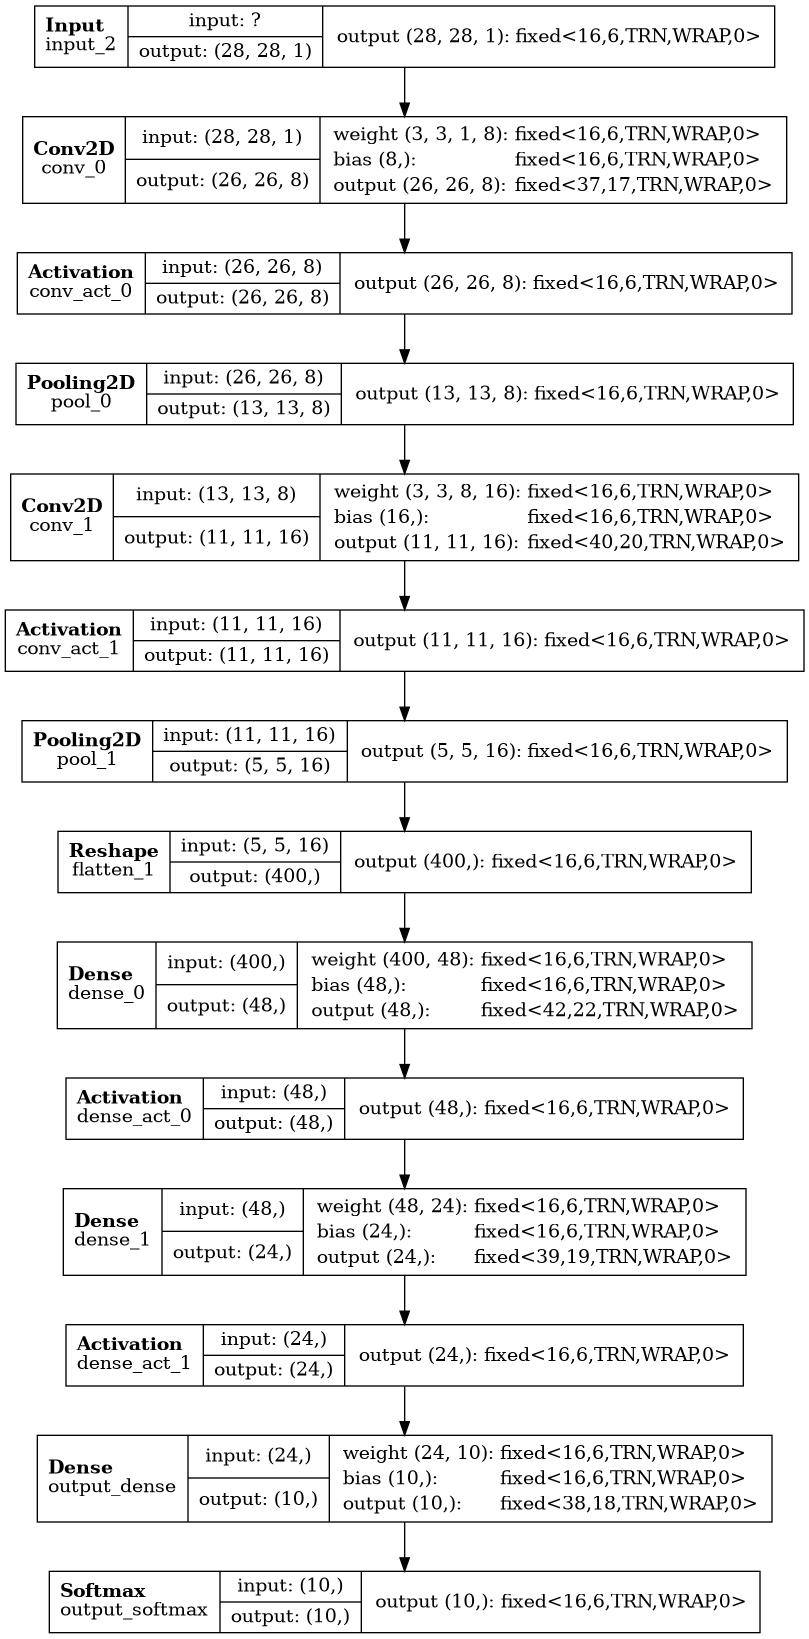

In [20]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input s

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

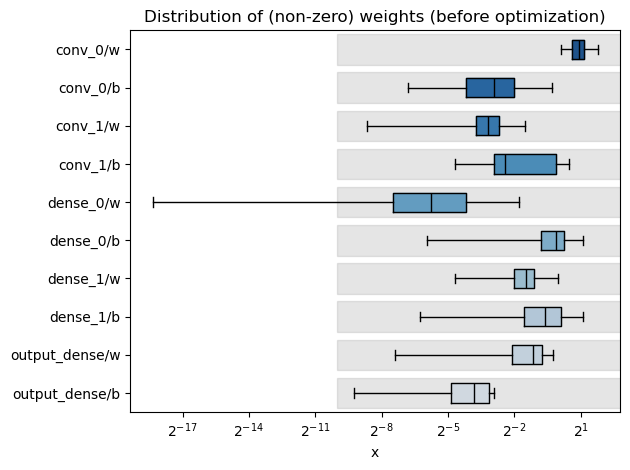

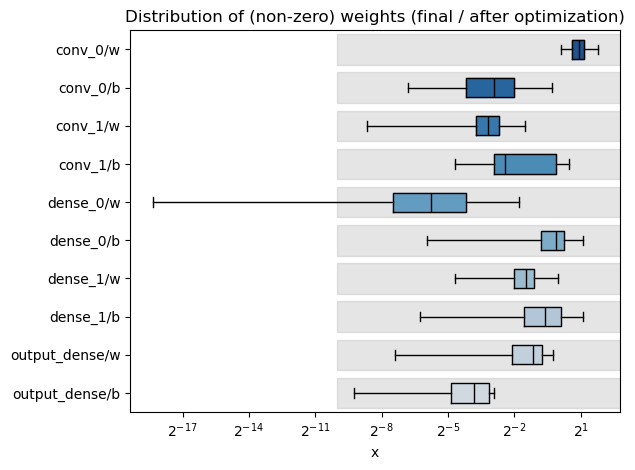

In [21]:
from hls4ml.model.profiling import numerical

numerical(model=model, hls_model=hls_model)

In [22]:

# Generate config from QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)
# Set model-level precision
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'

# Force Resource strategy globally
for lname, lcfg in hls_config_q['LayerName'].items():
    lcfg['Strategy'] = 'Resource'

# Inject computed reuse factors
reuse_factors = reuse_percentage_to_factors(qmodel, serial_pct=0.125)
for lname, factor in reuse_factors.items():
    if lname in hls_config_q['LayerName']:
        hls_config_q['LayerName'][lname]['ReuseFactor'] = factor
    else:
        print(f"Warning: Layer {lname} not found in HLS config")
    

plotting.print_dict(hls_config_q)

save_proj_path = os.path.join(project_folder, 'Quantized')

# Convert and compile
hls_model_q = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config_q,
    output_dir=save_proj_path,
    backend='Vitis',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    part = 'xck26-sfvc784-2LV-c',
    project_name="quantized_cnn"
)

hls_model_q.compile()


/home/theodoros/miniconda3/envs/ai_on_fpga/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

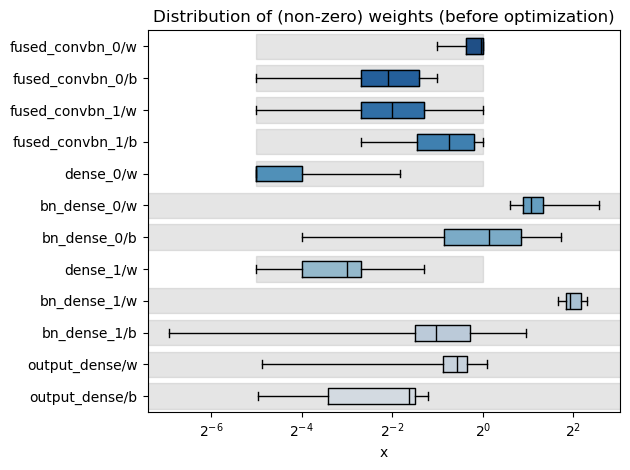

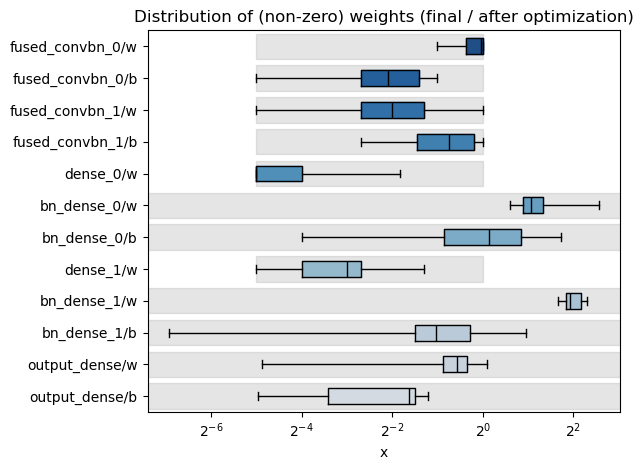

In [23]:
numerical(model=qmodel, hls_model=hls_model_q)

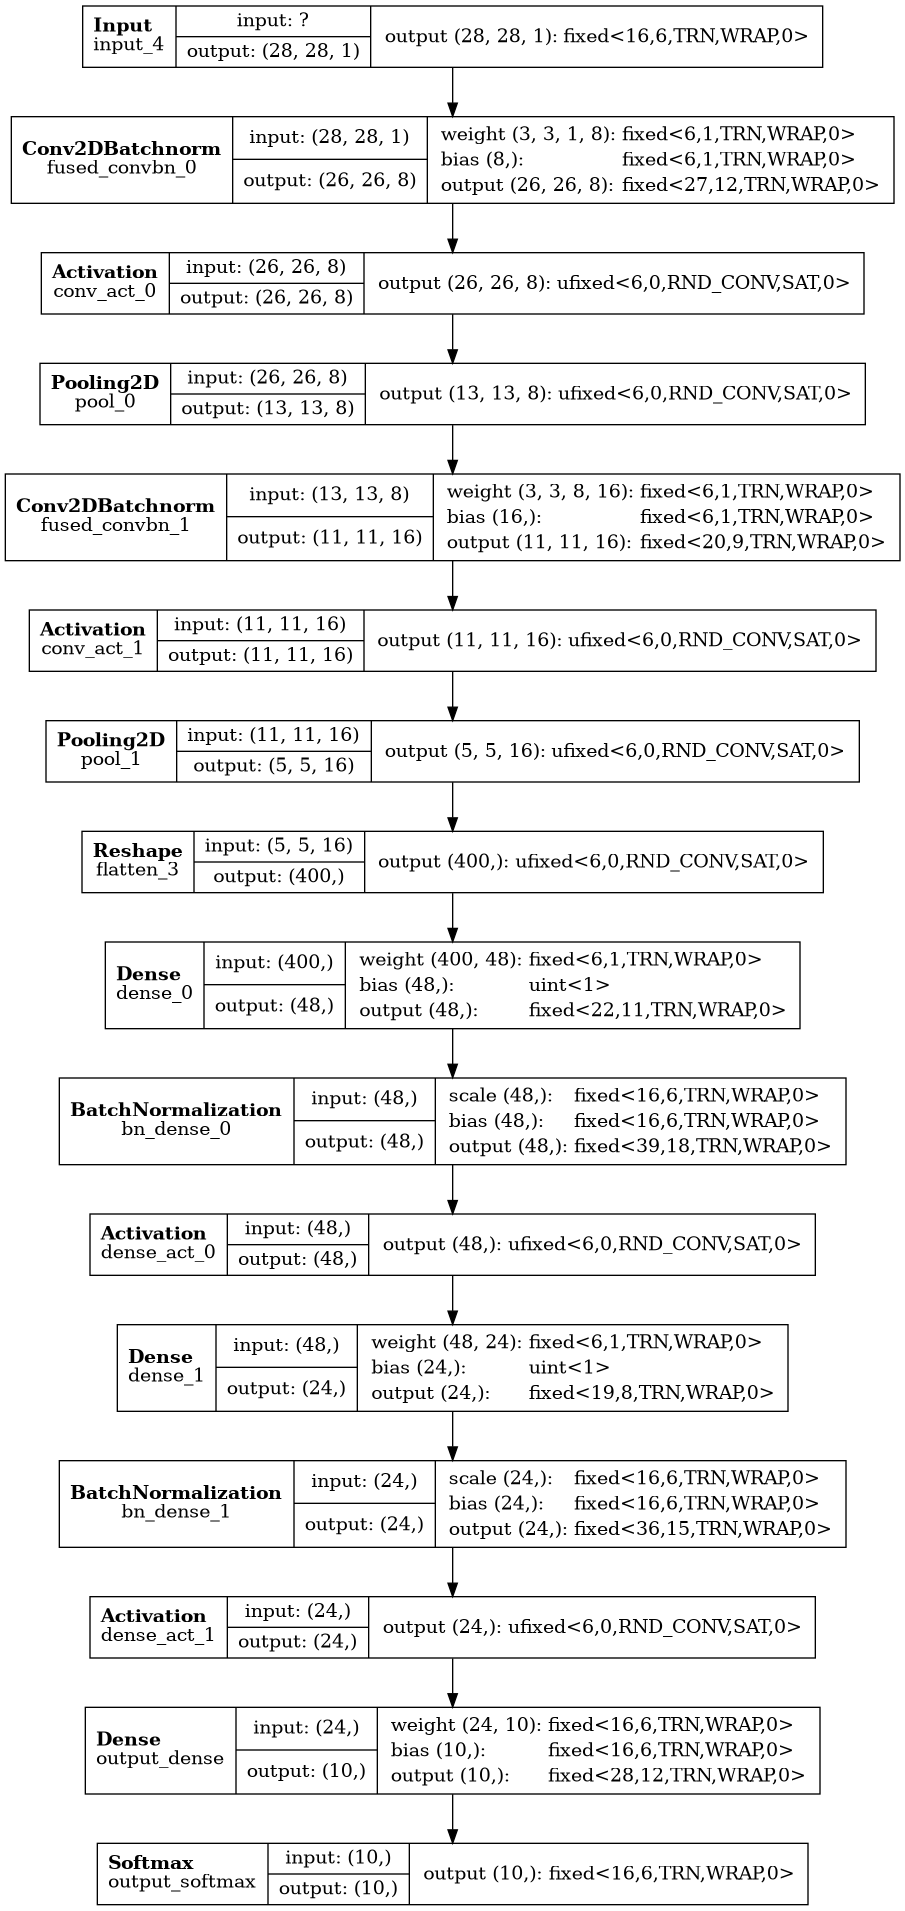

In [24]:
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [25]:
y_predict = model.predict(x_test)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 0s 1ms/step


In [26]:
y_predict_q = qmodel.predict(x_test)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 1s 2ms/step


Accuracy Keras:  0.9848
Accuracy hls4ml: 0.985
Accuracy Keras:  0.9802
Accuracy hls4ml: 0.9805


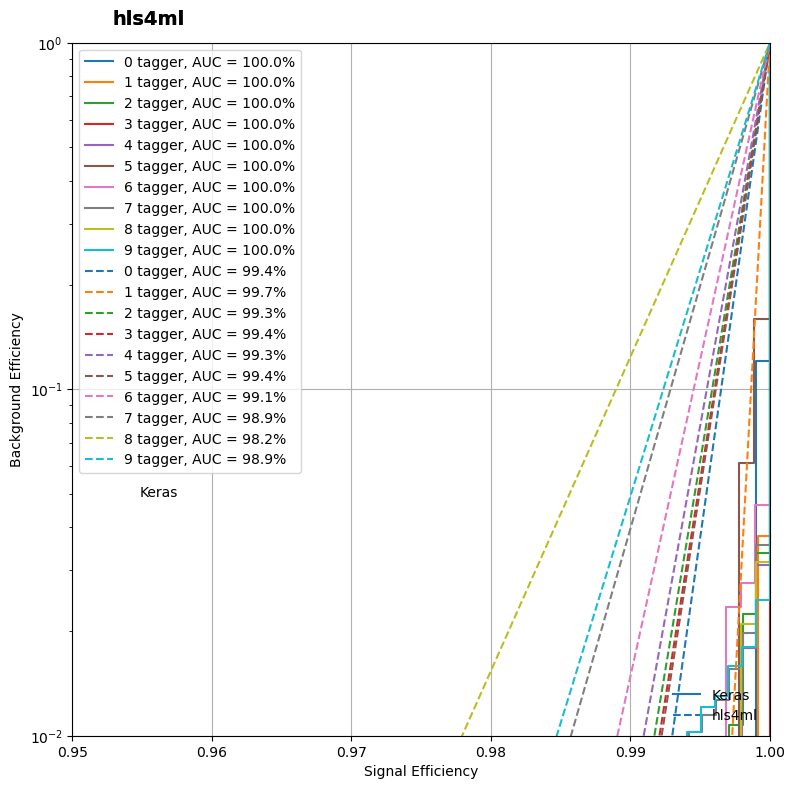

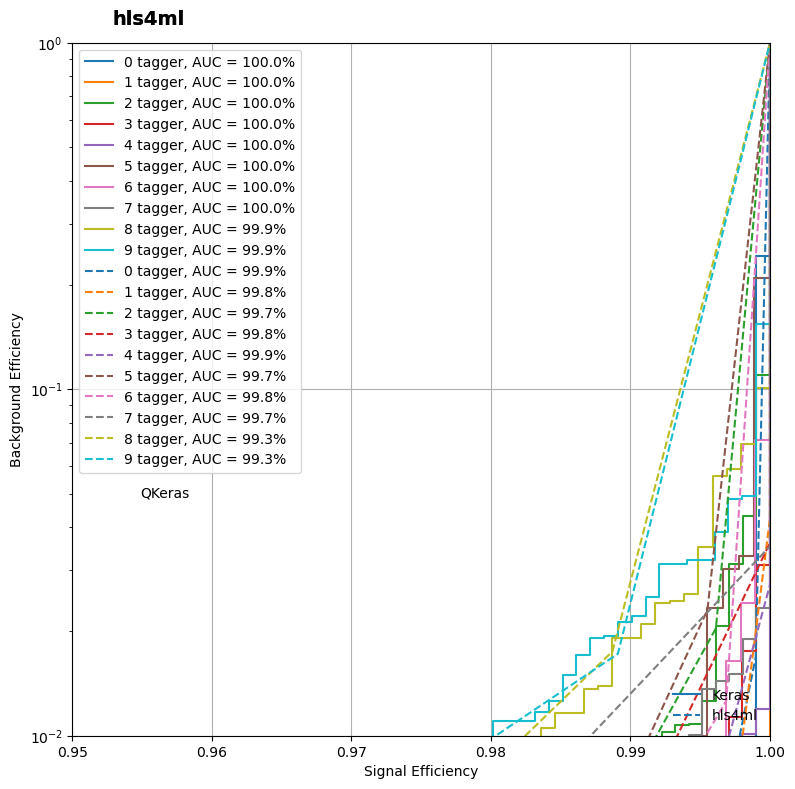

In [27]:
import utils.plotting as plotting
from sklearn.metrics import accuracy_score


def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i' % nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None)  # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i' % nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D

    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend

    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'], loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38, label, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.ylim(0.01, 1.0)
    plt.xlim(0.95, 1.0)


# Plot the pruned floating point model:
plotROC(y_test, y_predict, y_predict_hls4ml, label="Keras")

# Plot the pruned and quantized QKeras model
plotROC(y_test, y_predict_q, y_predict_hls4ml_q, label="QKeras")

In [28]:
from template_injector import TemplateInjector

injector = TemplateInjector(template_dir="templates")

injector.inject(
    project_dir="Projects/Baseline",
    project_name="baseline_cnn",
    force=True  # or False to skip existing files
)

injector.inject(
    project_dir="Projects/Quantized",
    project_name="quantized_cnn",
    force=True  # or False to skip existing files
)


Injected: Projects/Baseline/firmware/baseline_cnn_stream.cpp
Injected: Projects/Baseline/firmware/baseline_cnn_stream.h
Injected: Projects/Baseline/baseline_cnn_test.cpp
Copied: gen_tb.py → Projects/Baseline/gen_tb.py
Copied: compute_performance.py → Projects/Baseline/compute_performance.py
Copied: build_prj.tcl → Projects/Baseline/build_prj.tcl
Copied: golden_preds.py → Projects/Baseline/golden_preds.py
Injected: Projects/Quantized/firmware/quantized_cnn_stream.cpp
Injected: Projects/Quantized/firmware/quantized_cnn_stream.h
Injected: Projects/Quantized/quantized_cnn_test.cpp
Copied: gen_tb.py → Projects/Quantized/gen_tb.py
Copied: compute_performance.py → Projects/Quantized/compute_performance.py
Copied: build_prj.tcl → Projects/Quantized/build_prj.tcl
Copied: golden_preds.py → Projects/Quantized/golden_preds.py


In [29]:
import os
pwd = os.getcwd()
print(f"Current working directory: {pwd}")
build = True  # Set to True if you want to build the project, False to skip

Current working directory: /home/theodoros/Projects/AI_ON_FPGA


In [ ]:
build_project(project_dir=f"{project_folder}/Baseline",
    dataset="mnist",
    n_samples=100
)


[BUILD] Running: python gen_tb.py --dataset mnist --n-samples 100 --seed 42 --ap-total-bits 16 --ap-int-bits 6 --model keras_model.keras --save-labels
        cwd=/home/theodoros/Projects/AI_ON_FPGA/Projects/Baseline

[BUILD] Running: vitis-run --mode hls --tcl build_prj.tcl
        cwd=/home/theodoros/Projects/AI_ON_FPGA/Projects/Baseline

✅ Build completed successfully.


In [ ]:
build_project(project_dir=f"{project_folder}/Quantized",
    dataset="mnist",
    n_samples=100
)


[BUILD] Running: python gen_tb.py --dataset mnist --n-samples 100 --seed 42 --ap-total-bits 16 --ap-int-bits 6 --model keras_model.keras --save-labels
        cwd=/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized

[BUILD] Running: vitis-run --mode hls --tcl build_prj.tcl
        cwd=/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized

✅ Build completed successfully.
